In [1]:
import pandas as pd
df_feat = pd.read_csv('spa_pred.csv')[['Latitude','Longitude','target']]
# df_feat = pd.read_csv('real_pov.csv')[['LATNUM','LONGNUM','deprived_sev']]
# df_feat.rename(columns={'LATNUM': 'Latitude', 'LONGNUM': 'Longitude', 'deprived_sev': 'target'}, inplace=True)

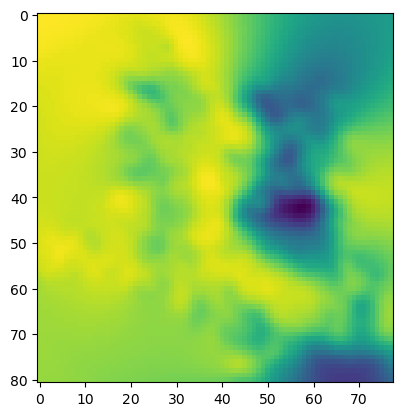

In [2]:
import numpy as np
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
g_df = gpd.GeoDataFrame(df_feat, crs="EPSG:4326", geometry=gpd.points_from_xy(df_feat["Longitude"], df_feat["Latitude"]))

g_df = g_df.to_crs("EPSG:3347")
g_df["Easting"], g_df["Northing"] = g_df.geometry.x, g_df.geometry.y
resolution = 20000  # cell size in meters
gridx = np.arange(g_df.bounds.minx.min(), g_df.bounds.maxx.max(), resolution)
gridy = np.arange(g_df.bounds.miny.min(), g_df.bounds.maxy.max(), resolution)

# Interpolate
krig = OrdinaryKriging(x=g_df["Easting"], y=g_df["Northing"], z=g_df['target'], variogram_model="spherical",
    # drift_terms=['regional_linear']
                        )
z, ss = krig.execute("grid", gridx, gridy)
z= z.clip(0,1)
plt.imshow(z);

In [3]:
import itertools
import numpy as np
import pandas as pd
from shapely.geometry import Polygon

def pixel2poly(x, y, z, resolution):
    """
    x: x coords of cell
    y: y coords of cell
    z: matrix of values for each (x,y)
    resolution: spatial resolution of each cell
    """
    polygons = []
    values = []
    half_res = resolution / 2
    for i, j  in (itertools.product(range(len(x)), range(len(y)))):
        minx, maxx = x[i] - half_res, x[i] + half_res
        miny, maxy = y[j] - half_res, y[j] + half_res
        polygons.append(Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)]))
        if isinstance(z, (int, float)):
            values.append(z)
        else:
            values.append(z[j, i])
    return polygons, values

In [4]:
mean = df_feat.target.mean()
std = df_feat.target.std()

In [5]:
target = 'deprived_sev'

In [6]:
kenya_map_shape = 'gadm41_KEN_shp/gadm41_KEN_2.shp'
gdf = gpd.read_file(kenya_map_shape)

In [7]:
# gdf.to_file("gadm41_KEN_2_shp.geojson", driver="GeoJSON")

In [8]:
def get_coords(row):
    x_list = row.geometry.geoms[0].exterior.coords.xy[0]
    y_list = row.geometry.geoms[0].exterior.coords.xy[1]

    return (np.array(x_list),np.array(y_list))

In [9]:
gdf_json = gpd.read_file("gadm41_KEN_2_shp.geojson")

In [10]:
import plotly.express as px
from tqdm import tqdm
import plotly.graph_objects as go
polygons, values = pixel2poly(gridx, gridy, z, resolution)
values_percent = [100*val for val in values]
kenya_model = (gpd.GeoDataFrame({"Severe Deprivation %": values_percent}, geometry=polygons, crs="EPSG:3347")
                   .to_crs("EPSG:4326")
               )
kenya_model = gpd.clip(kenya_model,gdf)
fig = px.choropleth_mapbox(kenya_model, geojson=kenya_model.geometry, locations=kenya_model.index,
                           color="Severe Deprivation %", color_continuous_scale="Viridis",
                           range_color=[0,100],
                           center={"lat": 0.0236, "lon": 37.9062}, zoom=5,
                           mapbox_style="white-bg")
fig.update_layout(coloraxis_showscale=False)
fig.update_traces(marker_line_width=0)


fig.add_trace(go.Choroplethmapbox(
    geojson=gdf.__geo_interface__,
    locations=gdf.index,
    z=gdf.index,  # This is just a placeholder, we're not actually coloring by this
    colorscale=[[0, 'rgba(0,0,0,0)'], [1, 'rgba(0,0,0,0)']],  # Transparent fill
    marker_line_color='black',
    marker_line_width=0.5,
    showscale=False,
))
fig.update_layout(margin=dict(l=0, r=0, t=30, b=10))
fig.write_image("spatial_pred_2.pdf")